# Predistrain detection on road.

### Import Library

In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from matplotlib import pyplot as plt
%matplotlib inline

### Load the images

In [2]:
# Function to load and preprocess images
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            images.append(img)
    return np.array(images)

In [3]:
# Paths to the folders containing images
folders = ["Bus", "Car", "Lorry", "Motorcycles", "Pedestrian", "Small Lorry", "Truck", "Van"]

In [4]:
current_directory = os.getcwd()

In [5]:
# Load and preprocess images for each class
class_images = {}
for folder in folders:
    folder_path = os.path.join(current_directory, folder)  # Replace with actual path
    class_images[folder] = load_images_from_folder(folder_path)

### Display few pictures of each class

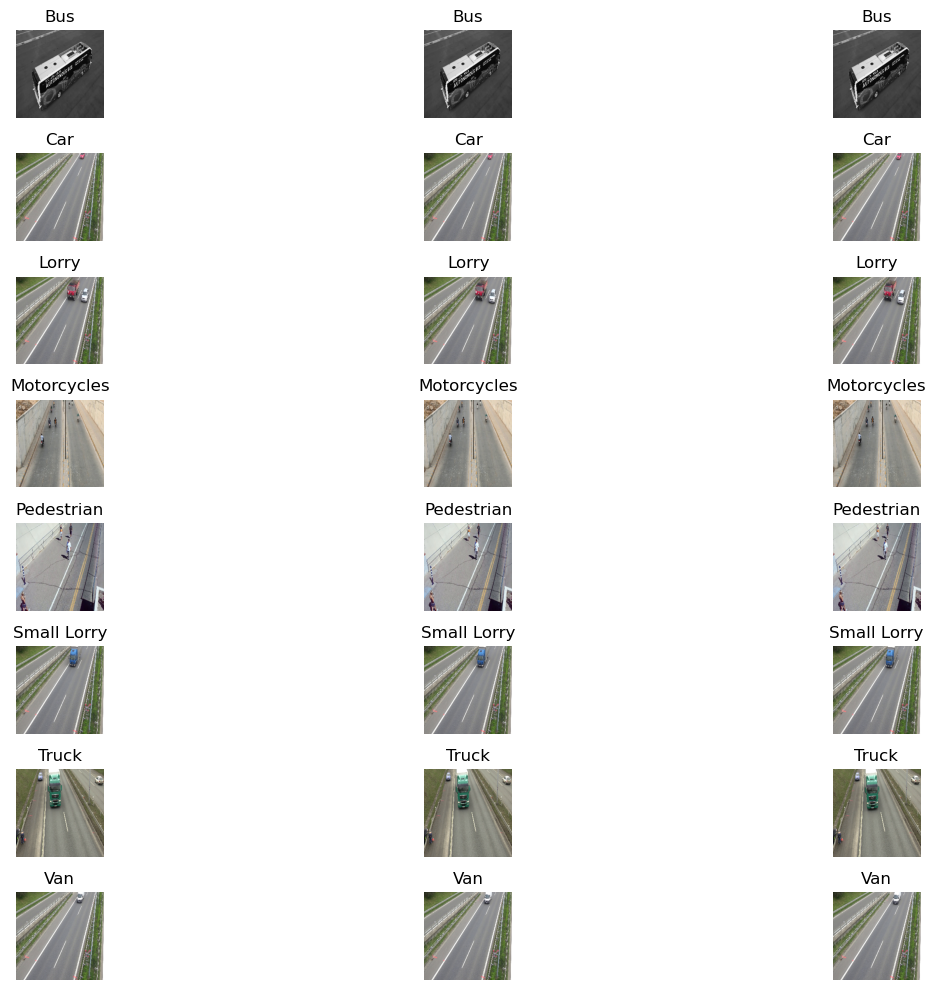

In [42]:
# Visualize a few images from each class
num_images_to_visualize = 3  # Number of images to visualize from each class

plt.figure(figsize=(15, 10))

for idx, folder in enumerate(folders):
    images = class_images[folder]
    for i in range(num_images_to_visualize):
        plt.subplot(len(folders), num_images_to_visualize, idx * num_images_to_visualize + i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(folder)
        plt.axis("off")

plt.tight_layout()
plt.show()

### Plot the count of images of each class

In [7]:
# Function to count images in a folder
def count_images_in_folder(folder_path):
    return len(os.listdir(folder_path))

In [8]:
# Dictionary to store image counts for each class
image_counts = {}

In [9]:
# Calculate image counts for each class
for folder in folders:
    folder_path = os.path.join(current_directory, folder)  # Replace with actual path
    image_counts[folder] = count_images_in_folder(folder_path)

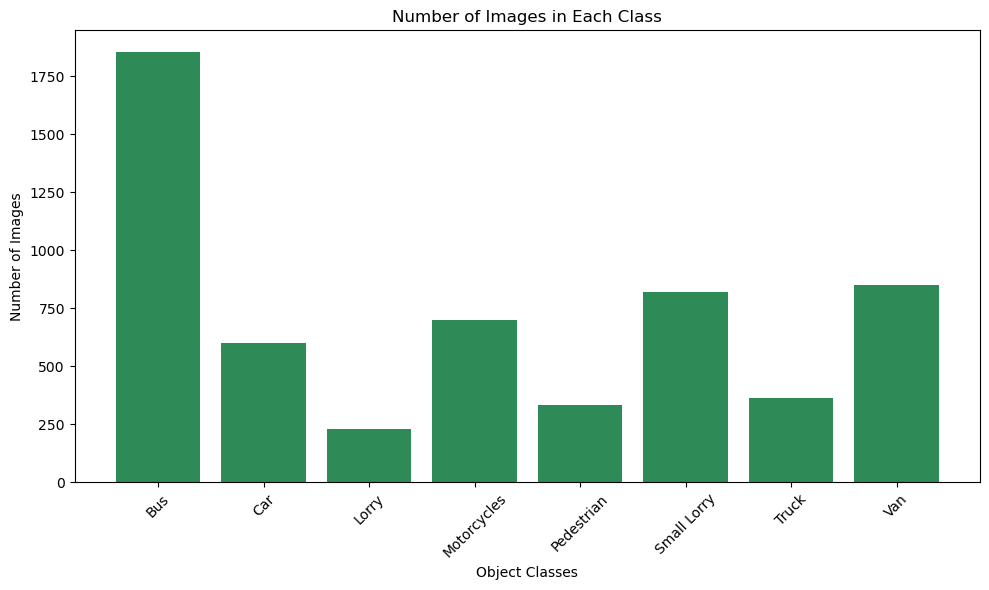

In [10]:
# Plot a histogram of image counts
plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color='seagreen')
plt.xlabel('Object Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the histogram plot
plt.show()

### Prepare train and test dataset.

In [44]:
# Prepare training data and labels
train_images = []
train_labels = []
for idx, folder in enumerate(folders):
    images = class_images[folder]
    labels = [idx] * len(images)
    train_images.extend(images)
    train_labels.extend(labels)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [45]:
# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [46]:
# Split the training data into optimization data (10%) and remaining data (90%)
opt_train_images, train_images, opt_train_labels, train_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

In [47]:
# Normalize pixel values to range [0, 1]
opt_train_images = opt_train_images.astype('float32') / 255.0
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [48]:
# Print the shapes of train and test datasets
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Train Images Shape:", opt_train_images.shape)
print("Train Labels Shape:", opt_train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

Train Images Shape: (460, 224, 224, 3)
Train Labels Shape: (460,)
Train Images Shape: (4138, 224, 224, 3)
Train Labels Shape: (4138,)
Test Images Shape: (1150, 224, 224, 3)
Test Labels Shape: (1150,)
Test Images Shape: (1150, 224, 224, 3)
Test Labels Shape: (1150,)


### Model Creaction-

In [49]:
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(folders), activation='softmax')  # Output layer with number of classes as units and softmax activation
])

In [50]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
# Optimize the model with 10% of training data
model.fit(opt_train_images, opt_train_labels, epochs=3, batch_size=32)

Epoch 1/3
130/130 [==============================] - 277s 2s/step - loss: 1.2685 - accuracy: 0.6602
Epoch 2/3
130/130 [==============================] - 280s 2s/step - loss: 0.4708 - accuracy: 0.8146
Epoch 3/3
130/130 [==============================] - 273s 2s/step - loss: 0.3049 - accuracy: 0.8770


In [52]:
# Evaluate the model's performance on the optimization data
opt_loss, opt_accuracy = model.evaluate(opt_train_images, opt_train_labels)
print(f"Optimization Data - Loss: {opt_loss:.4f}, Accuracy: {opt_accuracy:.4f}")

130/130 [==============================] - 66s 500ms/step - loss: 0.1644 - accuracy: 0.9538
Optimization Data - Loss: 0.1644, Accuracy: 0.9538


In [53]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [54]:
# Train the model with the remaining 90% of training data
history = model.fit(train_images, train_labels, epochs=15, batch_size=32, validation_data=(test_images, test_labels),  callbacks=callbacks)

Epoch 1/15
15/15 [==============================] - 55s 4s/step - loss: 0.2943 - accuracy: 0.8870 - val_loss: 0.2147 - val_accuracy: 0.9278 - lr: 0.0010
Epoch 2/15
15/15 [==============================] - 47s 3s/step - loss: 0.2041 - accuracy: 0.9304 - val_loss: 0.1884 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 3/15
15/15 [==============================] - 48s 3s/step - loss: 0.1938 - accuracy: 0.9304 - val_loss: 0.2184 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 4/15
15/15 [==============================] - 50s 3s/step - loss: 0.1152 - accuracy: 0.9652 - val_loss: 0.1743 - val_accuracy: 0.9261 - lr: 0.0010
Epoch 5/15
15/15 [==============================] - 48s 3s/step - loss: 0.1241 - accuracy: 0.9543 - val_loss: 0.1695 - val_accuracy: 0.9322 - lr: 0.0010
Epoch 6/15
15/15 [==============================] - 49s 3s/step - loss: 0.1068 - accuracy: 0.9652 - val_loss: 0.2974 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 7/15
15/15 [==============================] - 48s 3s/step - loss: 0.0974 - a

In [55]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

36/36 [==============================] - 18s 505ms/step - loss: 0.1695 - accuracy: 0.9322
Test Loss: 0.16953061521053314
Test Accuracy: 0.9321739077568054


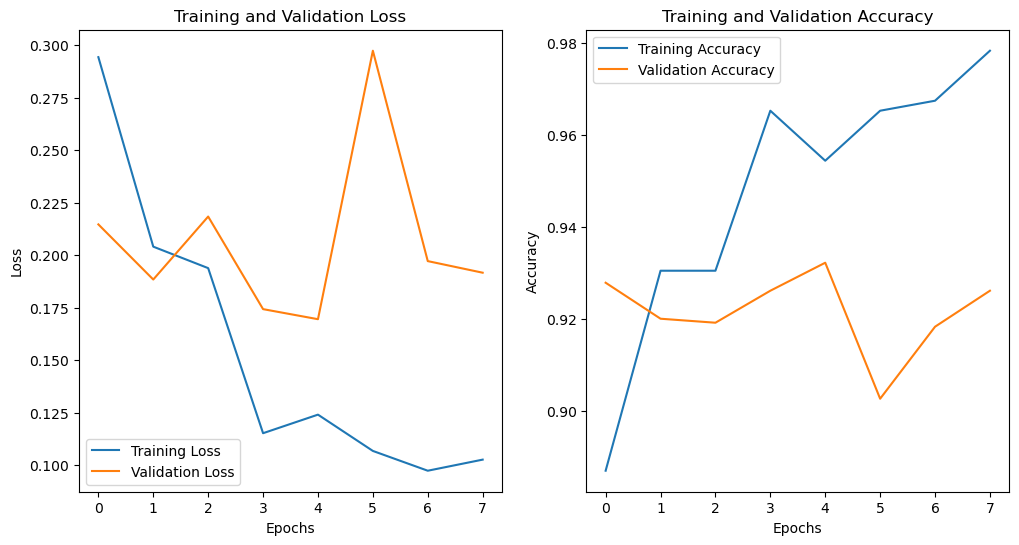

In [56]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

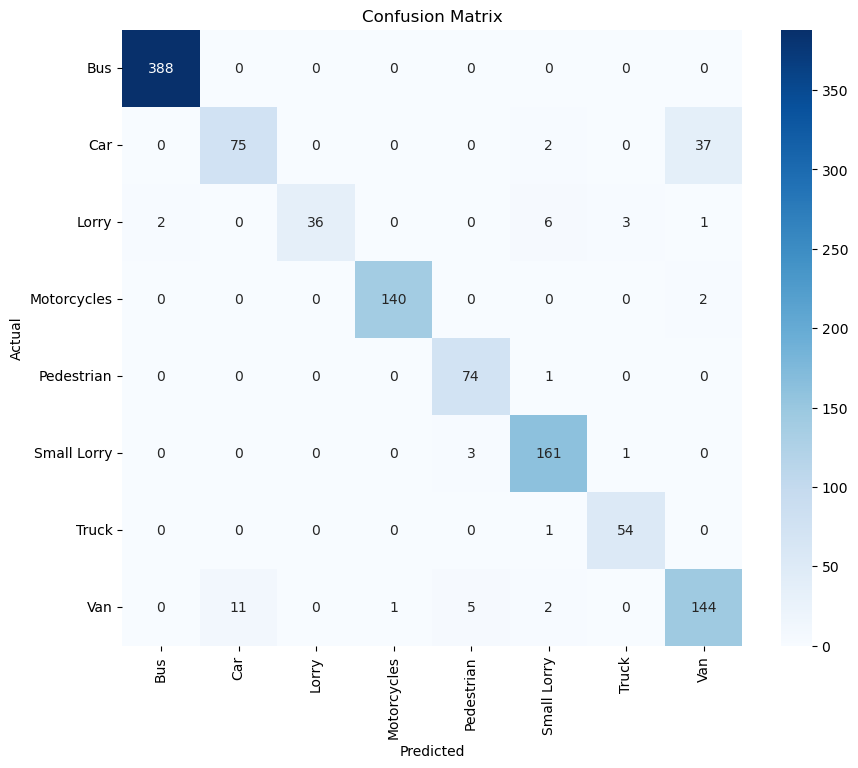

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=folders, yticklabels=folders)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [58]:
from sklearn.metrics import precision_score, recall_score

# Predict classes for test data
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Calculate precision and recall
precision = precision_score(test_labels, test_predictions_classes, average='weighted')
recall = recall_score(test_labels, test_predictions_classes, average='weighted')

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)

36/36 [==============================] - 18s 510ms/step
Precision: 0.9342884547216802
Recall: 0.9321739130434783


In [73]:
F1_Score = 2*((precision*recall)/(precision+recall))
print('F1 Score is= ',F1_Score*100)

F1 Score is=  93.32299860854562


1/1 [==============================] - 0s 98ms/step


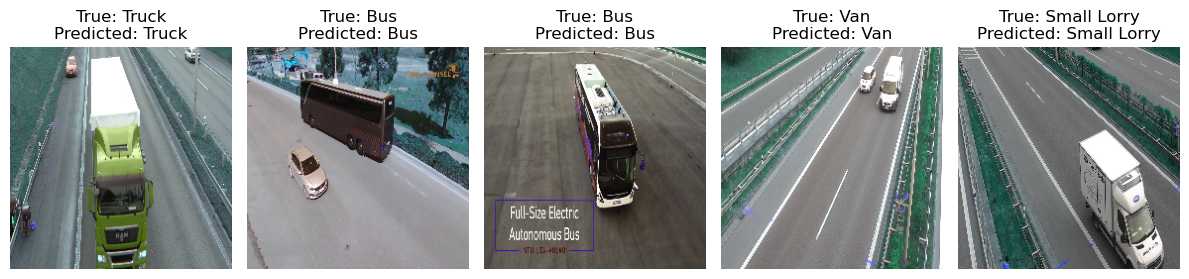

In [60]:
# Select a few sample images from the test set
num_sample_images = 5
sample_indices = np.random.choice(len(test_images), num_sample_images, replace=False)
sample_images = test_images[sample_indices]
sample_labels = test_labels[sample_indices]

# Predict classes for the sample images using the trained model
predicted_probs = model.predict(sample_images)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Create a dictionary to map class index to class name
class_idx_to_name = {idx: folder for idx, folder in enumerate(folders)}

# Plot the sample images with their predicted classes
plt.figure(figsize=(12, 8))
for i in range(num_sample_images):
    plt.subplot(1, num_sample_images, i + 1)
    plt.imshow(sample_images[i])
    true_label = class_idx_to_name[sample_labels[i]]
    predicted_label = class_idx_to_name[predicted_classes[i]]
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Object detection using YOLO

In [61]:
from ultralytics import YOLO
import PIL 
from PIL import Image
from IPython.display import display
import os 
import pathlib 

In [62]:
model2 = YOLO("yolov8m.pt")

In [63]:
results=model2.predict(source="1478020284198449721.jpg",
              save=True, conf=0.2,iou=0.5)


image 1/1 C:\Users\Arnab Hati\Documents\NCI_LAB\SEM2\DMML2\CA1\1478020284198449721.jpg: 416x640 1 person, 2 cars, 1119.9ms
Speed: 13.0ms preprocess, 1119.9ms inference, 23.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict2


In [64]:
result = results[0]
box = result.boxes[0]

In [65]:
cords = box.xyxy[0].tolist()
class_id = box.cls[0].item()
conf = box.conf[0].item()
print("Object type:", class_id)
print("Coordinates:", cords)
print("Probability:", conf)

Object type: 2.0
Coordinates: [44.969322204589844, 139.36534118652344, 202.48681640625, 186.5614013671875]
Probability: 0.8727620840072632


In [66]:
for box in result.boxes:
    class_id = result.names[box.cls[0].item()]
    cords = box.xyxy[0].tolist()
    cords = [round(x) for x in cords]
    conf = round(box.conf[0].item(), 2)
    print("Object type:", class_id)
    print("Coordinates:", cords)
    print("Probability:", conf)
    print("---")

Object type: car
Coordinates: [45, 139, 202, 187]
Probability: 0.87
---
Object type: person
Coordinates: [306, 97, 347, 252]
Probability: 0.83
---
Object type: car
Coordinates: [252, 146, 279, 165]
Probability: 0.67
---


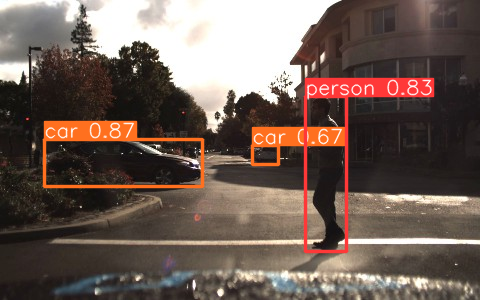

In [67]:
# Plotting results
plot = results[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

In [69]:
results1 = model2.predict(source="1478020463203275056.jpg",
              save=True, conf=0.2,iou=0.5)

Results = results1[0]


image 1/1 C:\Users\Arnab Hati\Documents\NCI_LAB\SEM2\DMML2\CA1\1478020463203275056.jpg: 416x640 9 cars, 11 traffic lights, 668.4ms
Speed: 2.6ms preprocess, 668.4ms inference, 6.8ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict2


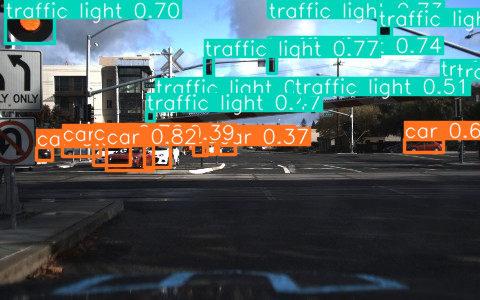

In [70]:
# Plotting results
plot = results1[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))